In [1]:
# ! pip install mlxtend

In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import tree
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import lasso_path

import sklearn.metrics as metrics
from sklearn.feature_selection import f_regression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder

from sklearn.model_selection import TimeSeriesSplit

from matplotlib.font_manager import FontProperties  
fontset02 = FontProperties(fname=r"/System/Library/Fonts/PingFang.ttc", size=12) #微軟標準



In [3]:
path_ = r'/Users/liang/Documents/NCKU_DS/資料科學/數位沙盒/clean_data'
data12_train = pd.read_csv(path_ + r'/12_data_train.csv')
data12_test = pd.read_csv(path_ + r'/12_data_test.csv')

In [4]:
data12_train.shape

(26539, 190)

In [5]:
data12_test.shape

(6603, 190)

In [6]:
colnames = data12_train.columns

In [7]:
X_train = data12_train.drop(['ID', '單價(萬/坪)'], axis=1)
y_train = data12_train['單價(萬/坪)']

X_test = data12_test.drop(['ID', '單價(萬/坪)'], axis=1)
y_test = data12_test['單價(萬/坪)']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2023)

In [8]:
y_train.describe()

count    26539.000000
mean        75.277252
std         30.331722
min          3.900000
25%         55.600000
50%         70.300000
75%         87.700000
max        671.200000
Name: 單價(萬/坪), dtype: float64

In [9]:
y_test.describe()

count    6603.000000
mean       75.345222
std        28.100916
min         6.900000
25%        55.900000
50%        71.200000
75%        89.000000
max       441.000000
Name: 單價(萬/坪), dtype: float64

### MAPE

In [10]:
def mape(y_ture, y_pred):
    return  np.sum(np.abs(y_ture-y_pred) / y_ture) / len(y_ture)

### adjusted R-squared def

In [11]:
def adjusted_r2(y, y_pred, X):
    r2 = r2_score(y, y_pred)
    n = X.shape[0] 
    p = X.shape[1] 
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    
    return adjusted_r2

### performance

In [12]:
def performance(model, X_train, y_train, X_test, y_test, note):
    # training
    y_train_pred = model.predict(X_train)
    
    #r2_train = r2_score(y_train, y_train_pred)
    adjr2_train = adjusted_r2(y_train, y_train_pred, X_train)
    rmse_train = mean_squared_error(y_train, y_train_pred)**0.5
    mape_train = mape(y_train, y_train_pred)

    # testing
    y_test_pred = model.predict(X_test)
    
    #r2_test = r2_score(y_test, y_test_pred)
    adjr2_test = adjusted_r2(y_test, y_test_pred, X_test)
    rmse_test = mean_squared_error(y_test, y_test_pred)**0.5
    mape_test = mape(y_test, y_test_pred)

#     print(note)
#     #print("training R-squared: ", round(r2_train, 4))
#     print("training Adjusted R-squared: ", round(adjr2_train, 4))
#     print("training RMSE: ", round(rmse_train, 4))
#     print("")
#     #print("testing R-squared: ", round(r2_test, 4))
#     print("testing Adjusted R-squared: ", round(adjr2_test, 4))
#     print("testing RMSE: ", round(rmse_test, 4))
    
    train_per = [adjr2_train, rmse_train, mape_train]
    test_per = [adjr2_test, rmse_test, mape_test]
    
    return train_per, test_per

### featureplot

In [13]:
def featureplot(importance, k, X_colname, title):
    '''
    importance: 
    k: number of features
    X_colname: colname of X (list)
    '''

    indices_of_largest = np.argsort(np.abs(importance), )[-k:][::-1]
    k_importance = [X_colname[i] for i in indices_of_largest]
    
    bar_colors = ['#ff7f0e' if importance[i] < 0 else '#1f77b4' for i in indices_of_largest]

    plt.figure(figsize=(6, 6))
    bars = plt.barh(k_importance, np.abs(importance)[indices_of_largest], color=bar_colors)
    plt.xlabel('Importance', size=12)
    plt.title(title, size=13, fontproperties=fontset02)
    plt.yticks(range(k), labels=k_importance, fontproperties=fontset02)
    
    plt.gca().invert_yaxis()  
    handles = [plt.Rectangle((0,0),1,1, color=color) for color in ['#1f77b4', '#ff7f0e']]

    plt.legend(handles, ['Positive', 'Negative'], title='Importance Sign')

    plt.savefig(f'Figures/importance/{title}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    
    return k_importance, np.abs(importance)[indices_of_largest]

In [14]:
# # try
# def featureplot(importance, k, X_colname, title):
#     '''
#     importance: 
#     k: number of features
#     X_colname: colname of X (list)
#     '''

#     indices_of_largest = np.argsort(np.abs(importance), )[-k:][::-1]
#     k_importance = [X_colname[i] for i in indices_of_largest]
    
#     plt.figure(figsize=(6, 6))
#     bars = plt.barh(k_importance, importance[indices_of_largest])
#     plt.xlabel('Importance', size=12)
#     plt.title(title, size=13, fontproperties=fontset02)
#     plt.yticks(range(k), labels=k_importance, fontproperties=fontset02)
    
#     plt.gca().invert_yaxis()  
# #     handles = [plt.Rectangle((0,0),1,1, color=color) for color in ['#1f77b4', '#ff7f0e']]

# #     plt.legend(handles, ['Positive', 'Negative'], title='Importance Sign')

#     plt.savefig(f'Figures/importance/{title}try.png', dpi=300, bbox_inches='tight')
#     plt.show()
    
    
#     return k_importance, np.abs(importance)[indices_of_largest]

### linear regression

In [15]:
linear = linear_model.LinearRegression()
linear_reg = linear.fit(X_train, y_train)

In [16]:
performance(linear_reg, X_train, y_train, X_test, y_test, "(不分區) Linear Regression:")

([0.6511480580349109, 17.851128556669394, 0.1648554303943834],
 [0.5646199411600819, 18.274629100380675, 0.18497085162126273])

In [17]:
# # try
# featureplot(linear_reg.coef_, 15, data12_train.columns, 'Coefficient of Linear Regression')

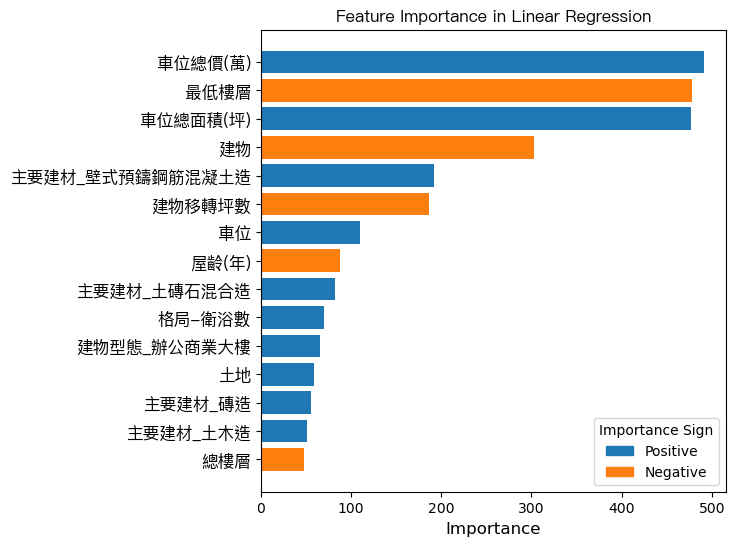

(['車位總價(萬)',
  '最低樓層',
  '車位總面積(坪)',
  '建物',
  '主要建材_壁式預鑄鋼筋混凝土造',
  '建物移轉坪數',
  '車位',
  '屋齡(年)',
  '主要建材_土磚石混合造',
  '格局-衛浴數',
  '建物型態_辦公商業大樓',
  '土地',
  '主要建材_磚造',
  '主要建材_土木造',
  '總樓層'],
 array([491.0078961 , 478.26234936, 476.38922472, 302.73203348,
        191.91755837, 186.36365098, 110.36866369,  87.7993936 ,
         82.2746396 ,  69.88642471,  65.31946064,  58.78691027,
         55.41561745,  50.63383471,  47.50326527]))

In [18]:
# 重要15
featureplot(linear_reg.coef_, 15, data12_train.columns, 'Feature Importance in Linear Regression')

### lasso regression

In [19]:
# %time
# param = np.arange(0, 0.5, 0.02)

# lasso_train_r2 = []
# lasso_train_adjr2 = []
# lasso_train_mse = []

# lasso_test_r2 = []
# lasso_test_adjr2 = []
# lasso_test_mse = []

# for lamb in param :
#     lasso = linear_model.Lasso(alpha=lamb)
#     linear_lasso = lasso.fit(X_train, y_train)
    
#     # train
#     y_train_pred = linear_lasso.predict(X_train)
#     r2_train = r2_score(y_train, y_train_pred)
#     adjr2_train = adjusted_r2(y_train, y_train_pred, X_train)
#     mse_train = mean_squared_error(y_train, y_train_pred)
    
    
#     # test
#     y_test_pred = linear_lasso.predict(X_test)
#     r2_test = r2_score(y_test, y_test_pred)
#     adjr2_test = adjusted_r2(y_test, y_test_pred, X_test)
#     mse_test = mean_squared_error(y_test, y_test_pred)

    
#     lasso_train_r2.append(r2_train)
#     lasso_train_adjr2.append(adjr2_train)
#     lasso_train_mse.append(mse_train)
    
#     lasso_test_r2.append(r2_test)
#     lasso_test_adjr2.append(adjr2_test)
#     lasso_test_mse.append(mse_test)


In [20]:
tscv = TimeSeriesSplit(n_splits=5)
lasso_cv = LassoCV(alphas=None, cv=tscv, max_iter=10000, random_state=2023)
linear_lasso = lasso_cv.fit(X_train, y_train)

print("最好的alpha值:", lasso_cv.alpha_)
alphas, coefs, dual_gaps = lasso_path(X_train, y_train, alphas=linear_lasso.alphas_) 

最好的alpha值: 0.02829470947744607


In [21]:
X_train.columns[linear_lasso.coef_==0]

Index(['交易日', '土地', '建物', '車位', '土地移轉坪數', '總樓層', '建物移轉坪數', '格局-房數', '格局-廳數',
       '格局-衛浴數',
       ...
       '失業率_33', '失業率_36', '貸款利率_3', '貸款利率_6', '貸款利率_15', '貸款利率_27', '貸款利率_30',
       '貸款利率_33', '貸款利率_36', '單價_24'],
      dtype='object', length=103)

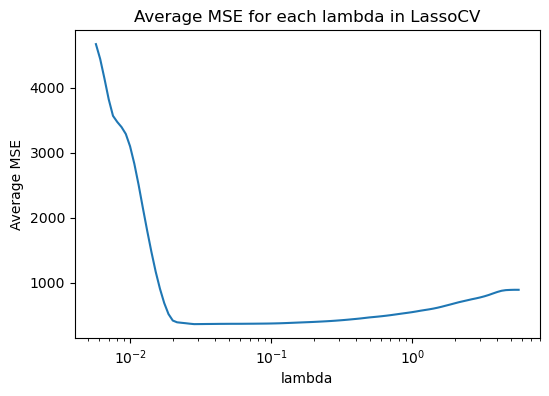

In [22]:
mse_path = linear_lasso.mse_path_

# 計算每個 alpha 的平均 MSE
average_mse = mse_path.mean(axis=1)

plt.figure(figsize=(6, 4))
plt.plot(linear_lasso.alphas_, average_mse)
plt.xscale('log')  
plt.xlabel('lambda')
plt.ylabel('Average MSE')
plt.title('Average MSE for each lambda in LassoCV')
plt.savefig(f'Figures/lasso_evaluate.png', dpi=300, bbox_inches='tight')

plt.show()

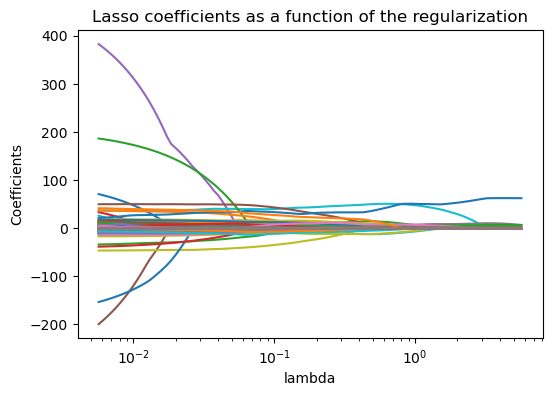

In [23]:
plt.figure(figsize=(6, 4))
for coef in coefs:
    plt.plot(alphas, coef)
plt.xscale('log')
plt.xlabel('lambda')
plt.ylabel('Coefficients')
plt.title('Lasso coefficients as a function of the regularization')
plt.axis('tight')
plt.savefig(f'Figures/lasso_lambda.png', dpi=300, bbox_inches='tight')
plt.show()

In [24]:
# 選定 lambda
lasso = linear_model.Lasso(alpha=0.02829470947744607)#lasso_cv.alpha_)
lasso_reg = lasso.fit(X_train, y_train)
performance(lasso_reg, X_train, y_train, X_test, y_test, "(不分區) Lasso Regression:")

([0.61343437898008, 18.79129536834408, 0.17041467829552845],
 [0.5702139831164782, 18.156847471906424, 0.1773782256422676])

In [25]:
# train
y_train_pred = lasso_reg.predict(X_train)
train_adj = adjusted_r2(y_train, y_train_pred, X_train.loc[:, lasso_reg.coef_!=0]) # p的計算要扣掉被shrink到0的變數

# test
y_test_pred = lasso_reg.predict(X_test)
test_adj = adjusted_r2(y_test, y_test_pred, X_test.loc[:, lasso_reg.coef_!=0]) # p的計算要扣掉被shrink到0的變數

print("lasso training adjusted r2: ", train_adj)
print("lasso testing adjusted r2: ", test_adj)

lasso training adjusted r2:  0.6149395488649723
lasso testing adjusted r2:  0.5770066729644148


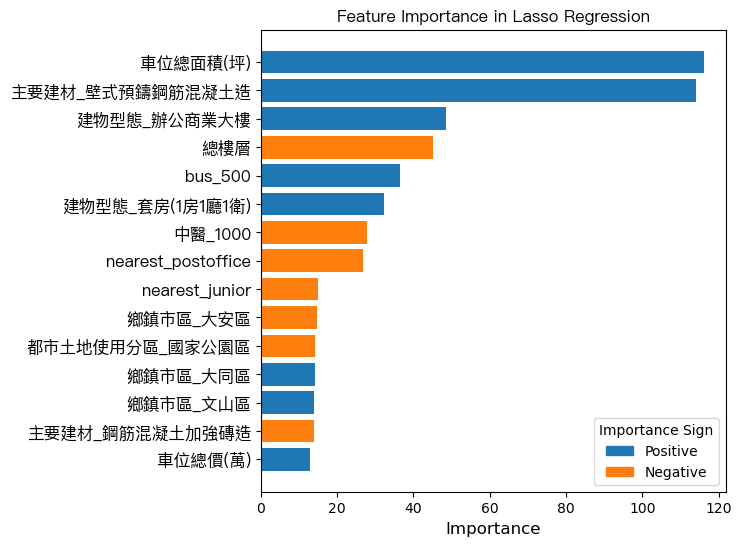

(['車位總面積(坪)',
  '主要建材_壁式預鑄鋼筋混凝土造',
  '建物型態_辦公商業大樓',
  '總樓層',
  'bus_500',
  '建物型態_套房(1房1廳1衛)',
  '中醫_1000',
  'nearest_postoffice',
  'nearest_junior',
  '鄉鎮市區_大安區',
  '都市土地使用分區_國家公園區',
  '鄉鎮市區_大同區',
  '鄉鎮市區_文山區',
  '主要建材_鋼筋混凝土加強磚造',
  '車位總價(萬)'],
 array([116.07798901, 114.17319627,  48.46938192,  45.07365472,
         36.38391077,  32.31937621,  27.74630219,  26.75582552,
         14.96987895,  14.6191996 ,  14.30371434,  14.2507733 ,
         14.01836132,  13.83294991,  12.86167272]))

In [26]:
# 重要15
featureplot(lasso_reg.coef_, 15, data12_train.columns, 'Feature Importance in Lasso Regression')

In [27]:
# 收縮至0
print(f'保留 {len(X_train.columns[lasso_reg.coef_!=0])} 個係數')
print(f'收縮至0(被刪除的係數)為:\n {X_train.columns[lasso_reg.coef_==0]}, \n共 {len(X_train.columns[lasso_reg.coef_==0])} 個')

保留 85 個係數
收縮至0(被刪除的係數)為:
 Index(['交易日', '土地', '建物', '車位', '土地移轉坪數', '總樓層', '建物移轉坪數', '格局-房數', '格局-廳數',
       '格局-衛浴數',
       ...
       '失業率_33', '失業率_36', '貸款利率_3', '貸款利率_6', '貸款利率_15', '貸款利率_27', '貸款利率_30',
       '貸款利率_33', '貸款利率_36', '單價_24'],
      dtype='object', length=103), 
共 103 個


In [28]:
lasso_col = X_train.columns[lasso_reg.coef_==0]

In [29]:
import pickle
with open(path_ + r'/lasso_shrink_to_0_all.pickle', 'wb') as file:
    pickle.dump(lasso_col, file)

### forward

In [30]:
%time
linear = linear_model.LinearRegression()

# 前向選擇
sfs_linear = SFS(linear, 
          k_features='best', 
          forward=True, 
          floating=False, 
          scoring='r2',
          cv=0)

sfs_linear_reg = sfs_linear.fit(X_train, y_train)
# 1:03

CPU times: user 5 µs, sys: 2 µs, total: 7 µs
Wall time: 5.25 µs


In [31]:
selected_features = X_train.columns[list(sfs_linear_reg.k_feature_idx_)]
selected_features

Index(['交易日', '緯度', '經度', '土地', '建物', '車位', '土地移轉坪數', '總樓層', '屋齡(年)', '建物移轉坪數',
       ...
       '單價_15', '單價_16', '單價_17', '單價_18', '單價_19', '單價_20', '單價_21', '單價_22',
       '單價_23', '單價_24'],
      dtype='object', length=149)

In [32]:
# forward移除的變數
print(X_train.columns.difference(selected_features))
len(X_train.columns.difference(selected_features))

Index(['主要建材_石造', '主要建材_鐵造', '主要用途_辦公室', '交易別_預售屋', '交易標的_房地(土地+建物)+車位',
       '失業率_12', '失業率_18', '失業率_21', '失業率_24', '失業率_3', '失業率_30', '失業率_33',
       '失業率_36', '建物型態_華廈(10層含以下有電梯)', '建築貸款餘額_15', '建築貸款餘額_24', '建築貸款餘額_30',
       '建築貸款餘額_33', '消費者物價指數_12', '消費者物價指數_18', '消費者物價指數_24', '消費者物價指數_33',
       '消費者物價指數_9', '管理組織(Y/N)_N', '貨幣供給額(Ｍ1Ｂ)_15', '貨幣供給額(Ｍ1Ｂ)_27',
       '貨幣供給額(Ｍ1Ｂ)_3', '貨幣供給額(Ｍ1Ｂ)_33', '貨幣供給額(Ｍ1Ｂ)_36', '貨幣供給額(Ｍ1Ｂ)_6',
       '貨幣供給額(Ｍ1Ｂ)_9', '貸款利率_12', '貸款利率_21', '貸款利率_24', '貸款利率_27', '貸款利率_3',
       '貸款利率_33', '鄉鎮市區_大同區', '頂樓註記(Y/N)_Y'],
      dtype='object')


39

In [33]:
X_train_selected = sfs_linear_reg.transform(X_train)
X_test_selected = sfs_linear_reg.transform(X_test)

print(X_train_selected.shape)
print(X_test_selected.shape)

(26539, 149)
(6603, 149)


In [34]:
linear = linear_model.LinearRegression()
linear_forward = linear.fit(X_train_selected, y_train)

In [35]:
performance(linear_forward, X_train_selected, y_train, X_test_selected, y_test, "(不分區) Linear Regression-- forward:")

([0.6516636223130815, 17.851128556669394, 0.16485543039438263],
 [0.5649137877251635, 18.3239171576982, 0.1831736049674244])

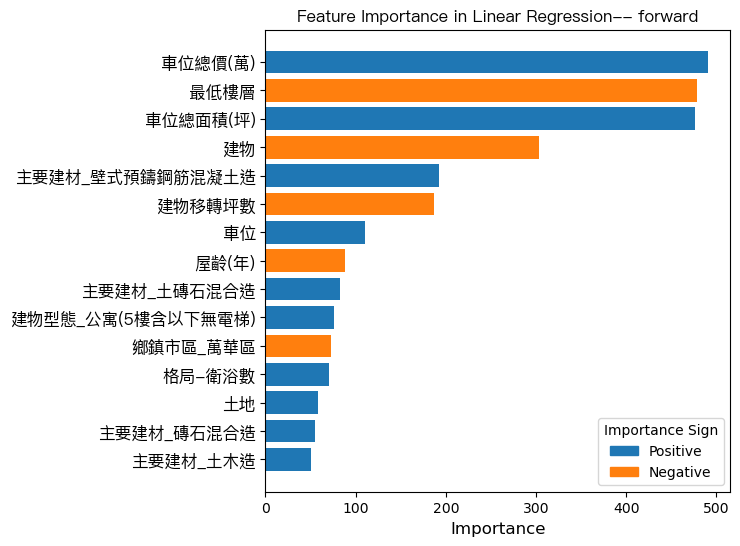

(['車位總價(萬)',
  '最低樓層',
  '車位總面積(坪)',
  '建物',
  '主要建材_壁式預鑄鋼筋混凝土造',
  '建物移轉坪數',
  '車位',
  '屋齡(年)',
  '主要建材_土磚石混合造',
  '建物型態_公寓(5樓含以下無電梯)',
  '鄉鎮市區_萬華區',
  '格局-衛浴數',
  '土地',
  '主要建材_磚石混合造',
  '主要建材_土木造'],
 array([491.0078961 , 478.26234936, 476.38922472, 302.73203348,
        191.91755837, 186.36365097, 110.36866369,  87.7993936 ,
         82.2746396 ,  76.18343471,  72.14787095,  69.88642471,
         58.78691027,  55.41561745,  50.63383471]))

In [36]:
# 重要15
X_train_selected = pd.DataFrame(X_train_selected, columns=selected_features)
featureplot(linear_forward.coef_, 15, data12_train.columns, 'Feature Importance in Linear Regression-- forward')

## 分區

In [37]:
dist = ['鄉鎮市區_中山區', '鄉鎮市區_中正區', '鄉鎮市區_信義區', '鄉鎮市區_內湖區', '鄉鎮市區_北投區', '鄉鎮市區_南港區',
        '鄉鎮市區_士林區', '鄉鎮市區_大同區', '鄉鎮市區_大安區', '鄉鎮市區_文山區', '鄉鎮市區_松山區', '鄉鎮市區_萬華區']

# d = ['zs', 'zz', 'xy', 'nh', 'bt', 'ng', 'sl', 'dt', 'da', 'ws', 'ss', 'wh']

In [38]:
X_train_dict = {}
y_train_dict = {}
X_test_dict = {}
y_test_dict = {}

for col in dist:
    X_train_dict[col] = X_train[X_train[col] == 1]
    X_test_dict[col] = X_test[X_test[col] == 1]
    y_train_dict[col] = y_train[X_train[col] == 1]
    y_test_dict[col] = y_test[X_test[col] == 1]
    

In [39]:
# 每個區資料
y_train_desp = {}
y_test_desp = {}

for district, df in y_train_dict.items():
    y_train_desp[district] = [np.mean(df), np.std(df), df.shape[0]]
    y_train_desp[district] = [np.mean(df), np.std(df), df.shape[0]]
    
for district, df in y_test_dict.items():
    y_test_desp[district] = [np.mean(df), np.std(df), df.shape[0]]
    y_test_desp[district] = [np.mean(df), np.std(df), df.shape[0]]

In [40]:
desp_train = pd.DataFrame(y_train_desp.values(), index=dist, columns=['平均單價', '標準差', '數量'])
desp_test = pd.DataFrame(y_test_desp.values(), index=dist, columns=['平均單價', '標準差', '數量'])

desp_train.to_csv(path_ + r'/desp_train.csv', sep=',', encoding='utf-8', index=True)
desp_test.to_csv(path_ + r'/desp_test.csv', sep=',', encoding='utf-8', index=True)


### linear

鄉鎮市區_中山區


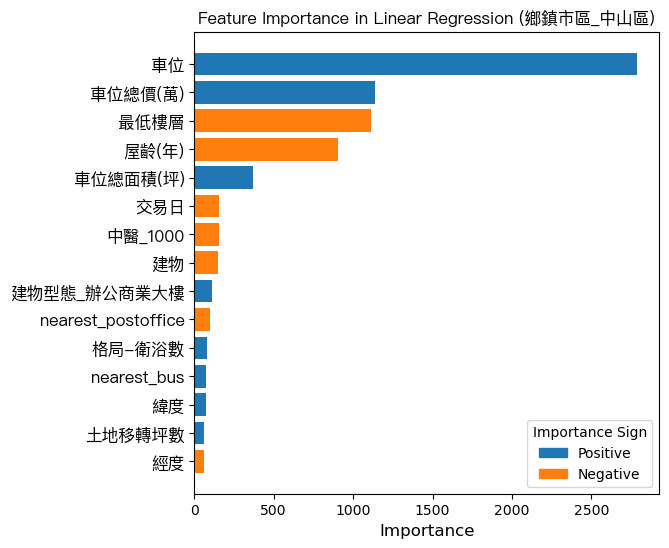

['車位', '車位總價(萬)', '最低樓層', '屋齡(年)', '車位總面積(坪)', '交易日', '中醫_1000', '建物', '建物型態_辦公商業大樓', 'nearest_postoffice', '格局-衛浴數', 'nearest_bus', '緯度', '土地移轉坪數', '經度']
 
鄉鎮市區_中正區


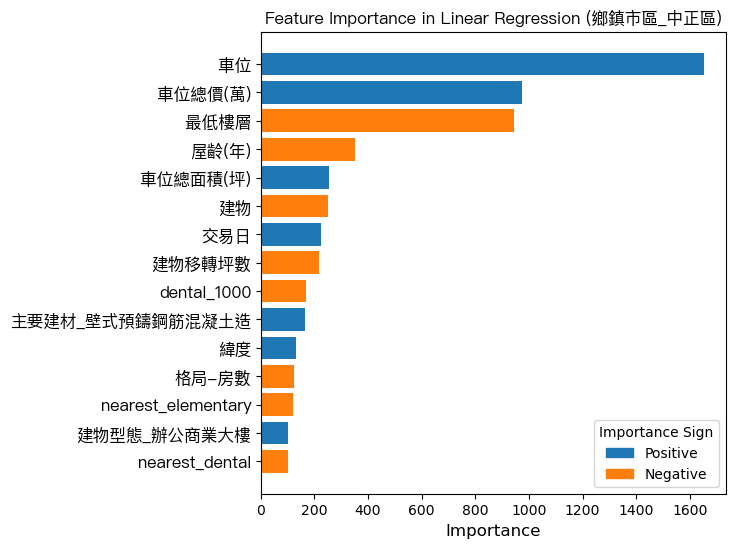

['車位', '車位總價(萬)', '最低樓層', '屋齡(年)', '車位總面積(坪)', '建物', '交易日', '建物移轉坪數', 'dental_1000', '主要建材_壁式預鑄鋼筋混凝土造', '緯度', '格局-房數', 'nearest_elementary', '建物型態_辦公商業大樓', 'nearest_dental']
 
鄉鎮市區_信義區


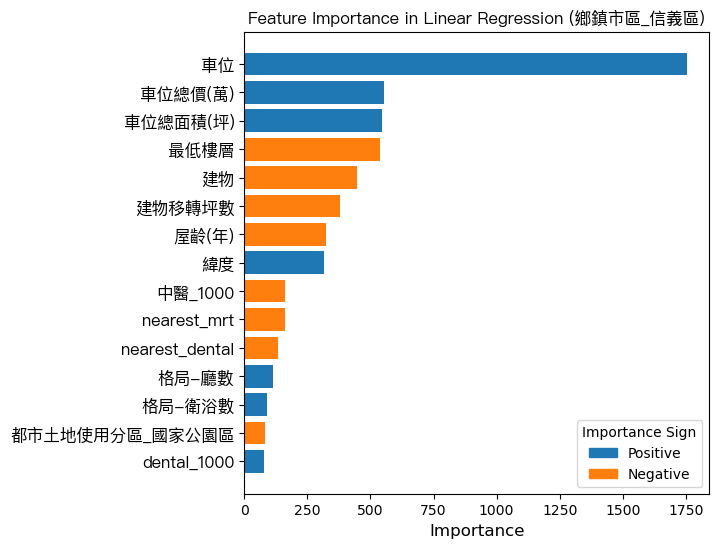

['車位', '車位總價(萬)', '車位總面積(坪)', '最低樓層', '建物', '建物移轉坪數', '屋齡(年)', '緯度', '中醫_1000', 'nearest_mrt', 'nearest_dental', '格局-廳數', '格局-衛浴數', '都市土地使用分區_國家公園區', 'dental_1000']
 
鄉鎮市區_內湖區


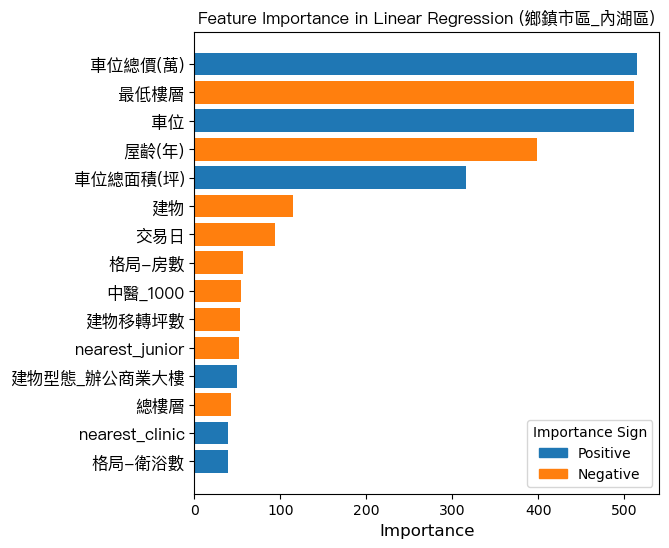

['車位總價(萬)', '最低樓層', '車位', '屋齡(年)', '車位總面積(坪)', '建物', '交易日', '格局-房數', '中醫_1000', '建物移轉坪數', 'nearest_junior', '建物型態_辦公商業大樓', '總樓層', 'nearest_clinic', '格局-衛浴數']
 
鄉鎮市區_北投區


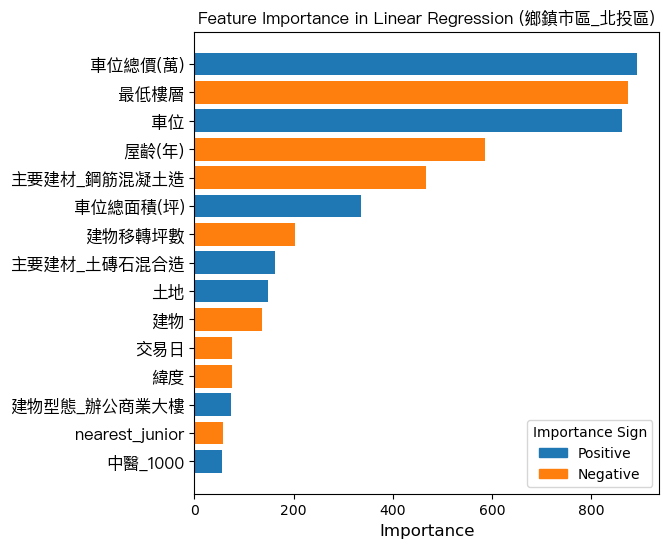

['車位總價(萬)', '最低樓層', '車位', '屋齡(年)', '主要建材_鋼筋混凝土造', '車位總面積(坪)', '建物移轉坪數', '主要建材_土磚石混合造', '土地', '建物', '交易日', '緯度', '建物型態_辦公商業大樓', 'nearest_junior', '中醫_1000']
 
鄉鎮市區_南港區


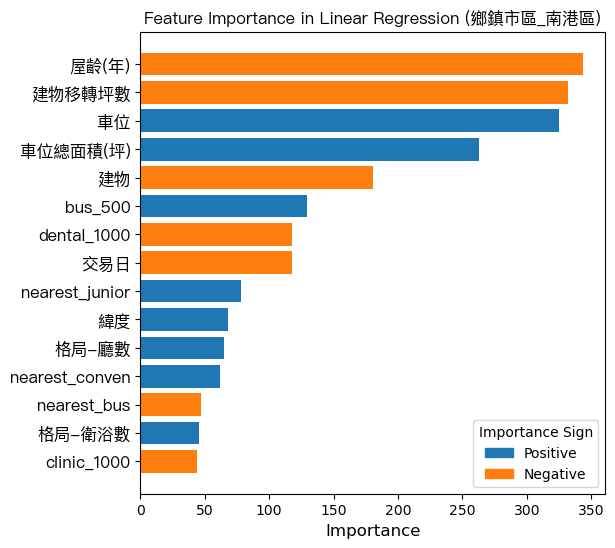

['屋齡(年)', '建物移轉坪數', '車位', '車位總面積(坪)', '建物', 'bus_500', 'dental_1000', '交易日', 'nearest_junior', '緯度', '格局-廳數', 'nearest_conven', 'nearest_bus', '格局-衛浴數', 'clinic_1000']
 
鄉鎮市區_士林區


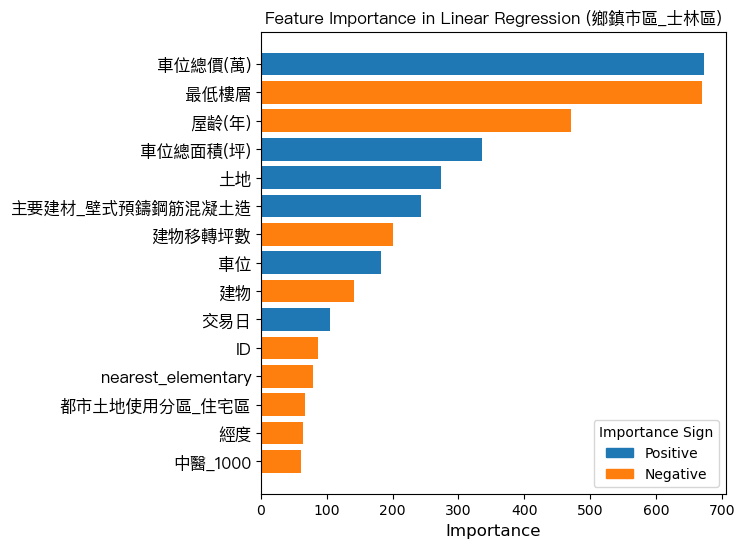

['車位總價(萬)', '最低樓層', '屋齡(年)', '車位總面積(坪)', '土地', '主要建材_壁式預鑄鋼筋混凝土造', '建物移轉坪數', '車位', '建物', '交易日', 'ID', 'nearest_elementary', '都市土地使用分區_住宅區', '經度', '中醫_1000']
 
鄉鎮市區_大同區


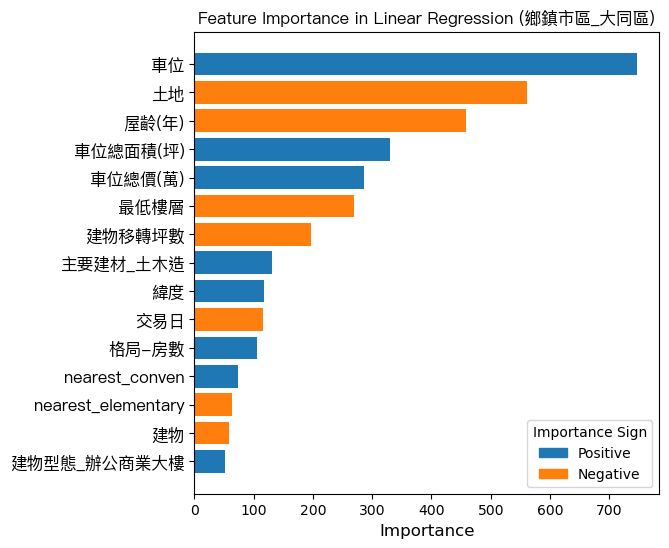

['車位', '土地', '屋齡(年)', '車位總面積(坪)', '車位總價(萬)', '最低樓層', '建物移轉坪數', '主要建材_土木造', '緯度', '交易日', '格局-房數', 'nearest_conven', 'nearest_elementary', '建物', '建物型態_辦公商業大樓']
 
鄉鎮市區_大安區


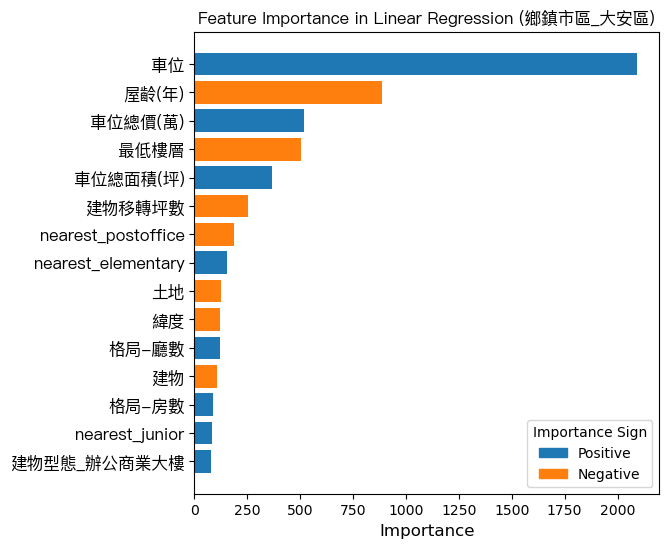

['車位', '屋齡(年)', '車位總價(萬)', '最低樓層', '車位總面積(坪)', '建物移轉坪數', 'nearest_postoffice', 'nearest_elementary', '土地', '緯度', '格局-廳數', '建物', '格局-房數', 'nearest_junior', '建物型態_辦公商業大樓']
 
鄉鎮市區_文山區


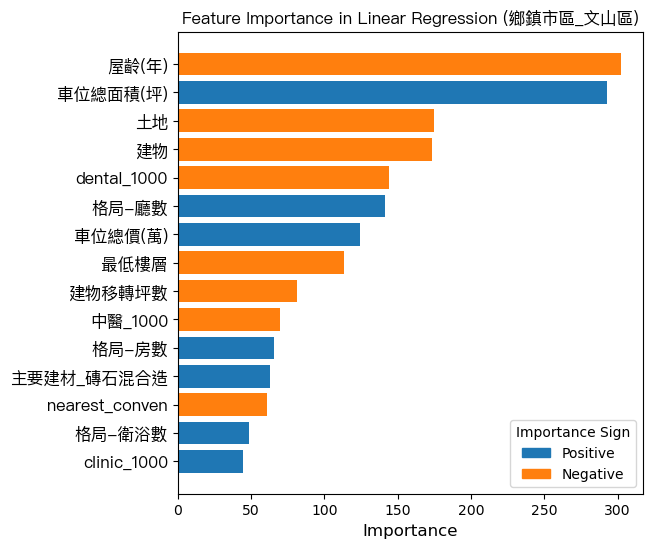

['屋齡(年)', '車位總面積(坪)', '土地', '建物', 'dental_1000', '格局-廳數', '車位總價(萬)', '最低樓層', '建物移轉坪數', '中醫_1000', '格局-房數', '主要建材_磚石混合造', 'nearest_conven', '格局-衛浴數', 'clinic_1000']
 
鄉鎮市區_松山區


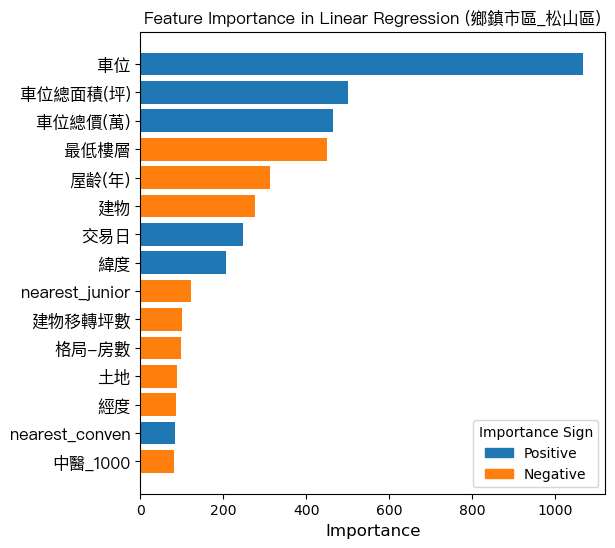

['車位', '車位總面積(坪)', '車位總價(萬)', '最低樓層', '屋齡(年)', '建物', '交易日', '緯度', 'nearest_junior', '建物移轉坪數', '格局-房數', '土地', '經度', 'nearest_conven', '中醫_1000']
 
鄉鎮市區_萬華區


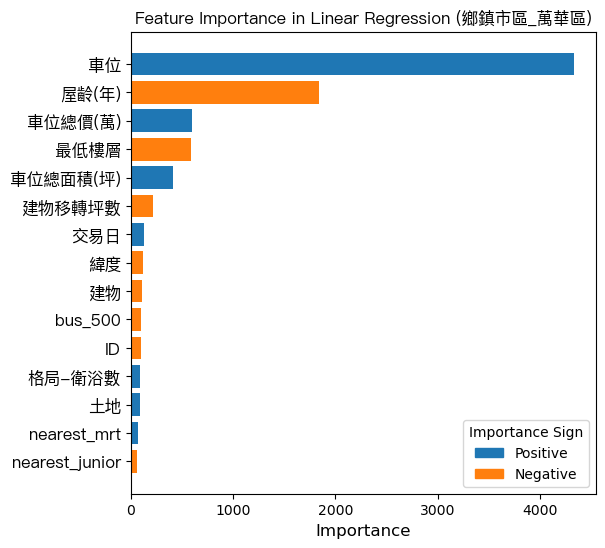

['車位', '屋齡(年)', '車位總價(萬)', '最低樓層', '車位總面積(坪)', '建物移轉坪數', '交易日', '緯度', '建物', 'bus_500', 'ID', '格局-衛浴數', '土地', 'nearest_mrt', 'nearest_junior']
 


In [41]:
df_train_per = []
df_test_per = []
df_importance = {}

for (name_X, X_train), (name_y, y_train), (name_X, X_test), (name_y, y_test) in zip(X_train_dict.items(), y_train_dict.items(), X_test_dict.items(), y_test_dict.items()):
    if name_X != name_y:
        raise ValueError("X和y的資料集名稱不匹配")
        
    print(name_X)
    linear = linear_model.LinearRegression()
    linear_reg = linear.fit(X_train, y_train)
    train_per, test_per = performance(linear_reg, X_train, y_train, X_test, y_test, f"{name_X} Linear Regression:")
    imp, _ = featureplot(linear_reg.coef_, 15, data12_train.columns, f'Feature Importance in Linear Regression ({name_X})') 
    print(imp)
    print(" ")
    
    df_train_per.append(train_per)
    df_test_per.append(test_per)
    df_importance[name_X] =  imp
    
    
linear_dist_train = pd.DataFrame(df_train_per, columns=['Adjusted R-squared', 'RMSE', 'MAPE'])
linear_dist_train.index = dist
linear_dist_test = pd.DataFrame(df_test_per, columns=['Adjusted R-squared', 'RMSE', 'MAPE'])
linear_dist_test.index = dist

In [42]:
linear_dist_train.to_csv(path_ + r'/linear_dist_train.csv', sep=',', encoding='utf-8', index=True)
linear_dist_test.to_csv(path_ + r'/linear_dist_test.csv', sep=',', encoding='utf-8', index=True)

In [43]:
# linear_dist_train = pd.read_csv(path_ + r'/linear_dist_train.csv')
# linear_dist_test = pd.read_csv(path_ + r'/linear_dist_test.csv')
# print('分區 training Adjusted R-squared 加權平均', np.sum(linear_dist_train['Adjusted R-squared']*(linear_dist_train['count']/np.sum(linear_dist_train['count']))))
# print('分區 testing Adjusted R-squared 加權平均', np.sum(linear_dist_test['Adjusted R-squared']*(linear_dist_test['count']/np.sum(linear_dist_test['count']))))

### lasso

0.19476534027838993


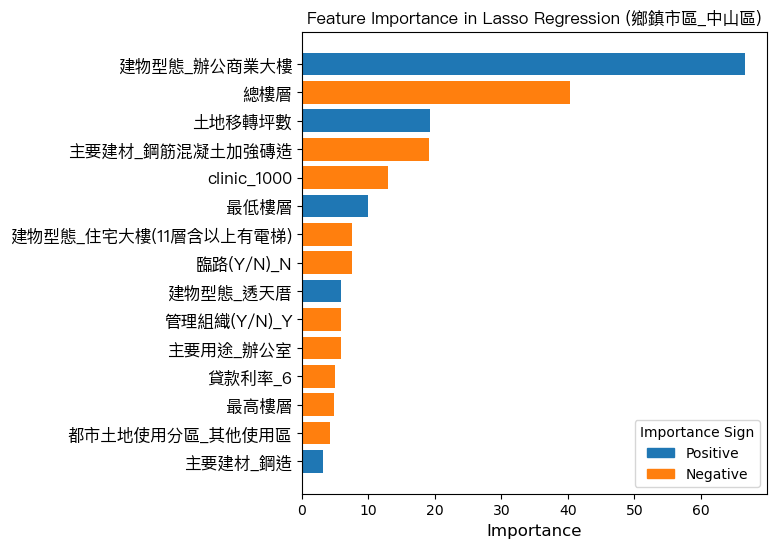

['建物型態_辦公商業大樓', '總樓層', '土地移轉坪數', '主要建材_鋼筋混凝土加強磚造', 'clinic_1000', '最低樓層', '建物型態_住宅大樓(11層含以上有電梯)', '臨路(Y/N)_N', '建物型態_透天厝', '管理組織(Y/N)_Y', '主要用途_辦公室', '貸款利率_6', '最高樓層', '都市土地使用分區_其他使用區', '主要建材_鋼造']
 
lasso training adjusted r2 !:  0.4796918747502458
lasso testing adjusted r2 !:  0.45736814044638163

保留 43 個係數
收縮至0(被刪除的係數)為:
 Index(['交易日', '緯度', '經度', '土地', '建物', '車位', '土地移轉坪數', '建物移轉坪數', '格局-房數',
       '格局-廳數',
       ...
       '貸款利率_6', '貸款利率_12', '貸款利率_15', '貸款利率_24', '貸款利率_27', '貸款利率_30',
       '貸款利率_33', '貸款利率_36', '單價_22', '單價_24'],
      dtype='object', length=145), 
共 145 個

0.28135071164543374


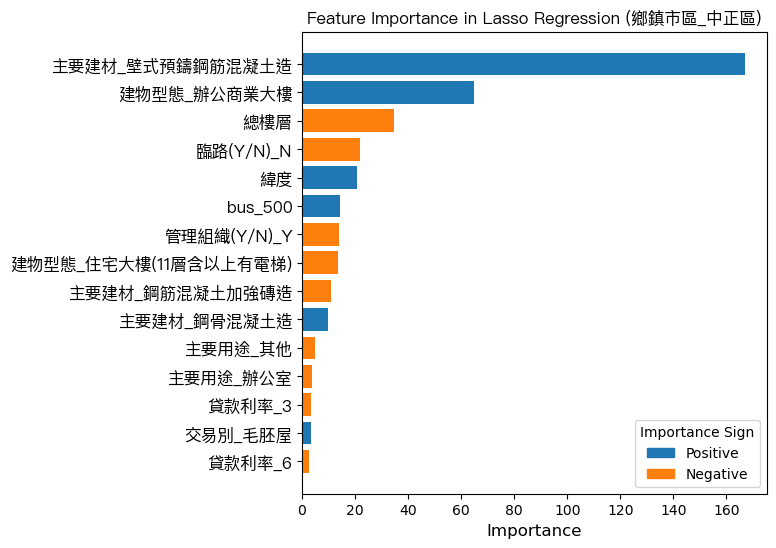

['主要建材_壁式預鑄鋼筋混凝土造', '建物型態_辦公商業大樓', '總樓層', '臨路(Y/N)_N', '緯度', 'bus_500', '管理組織(Y/N)_Y', '建物型態_住宅大樓(11層含以上有電梯)', '主要建材_鋼筋混凝土加強磚造', '主要建材_鋼骨混凝土造', '主要用途_其他', '主要用途_辦公室', '貸款利率_3', '交易別_毛胚屋', '貸款利率_6']
 
lasso training adjusted r2 !:  0.5848996885729089
lasso testing adjusted r2 !:  0.0372093176599978

保留 40 個係數
收縮至0(被刪除的係數)為:
 Index(['交易日', '緯度', '土地', '建物', '車位', '土地移轉坪數', '總樓層', '建物移轉坪數', '格局-房數',
       '格局-廳數',
       ...
       '貸款利率_21', '貸款利率_24', '貸款利率_27', '貸款利率_30', '貸款利率_33', '貸款利率_36',
       '單價_6', '單價_12', '單價_21', '單價_24'],
      dtype='object', length=148), 
共 148 個

0.06206431344082846


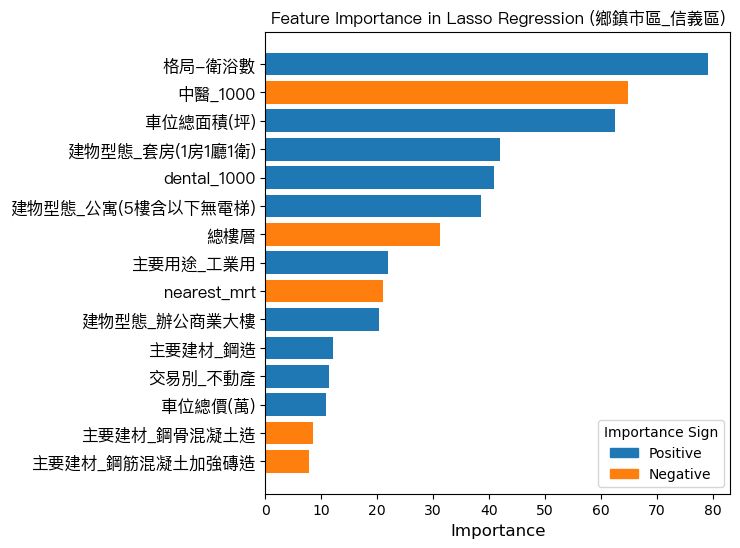

['格局-衛浴數', '中醫_1000', '車位總面積(坪)', '建物型態_套房(1房1廳1衛)', 'dental_1000', '建物型態_公寓(5樓含以下無電梯)', '總樓層', '主要用途_工業用', 'nearest_mrt', '建物型態_辦公商業大樓', '主要建材_鋼造', '交易別_不動產', '車位總價(萬)', '主要建材_鋼骨混凝土造', '主要建材_鋼筋混凝土加強磚造']
 
lasso training adjusted r2 !:  0.5599241640375021
lasso testing adjusted r2 !:  0.31143728550083083

保留 70 個係數
收縮至0(被刪除的係數)為:
 Index(['交易日', '緯度', '經度', '土地', '建物', '車位', '土地移轉坪數', '建物移轉坪數', '格局-房數',
       '格局-廳數',
       ...
       '貸款利率_3', '貸款利率_6', '貸款利率_12', '貸款利率_15', '貸款利率_24', '貸款利率_27',
       '貸款利率_30', '貸款利率_33', '貸款利率_36', '單價_24'],
      dtype='object', length=118), 
共 118 個

0.038568613832018366


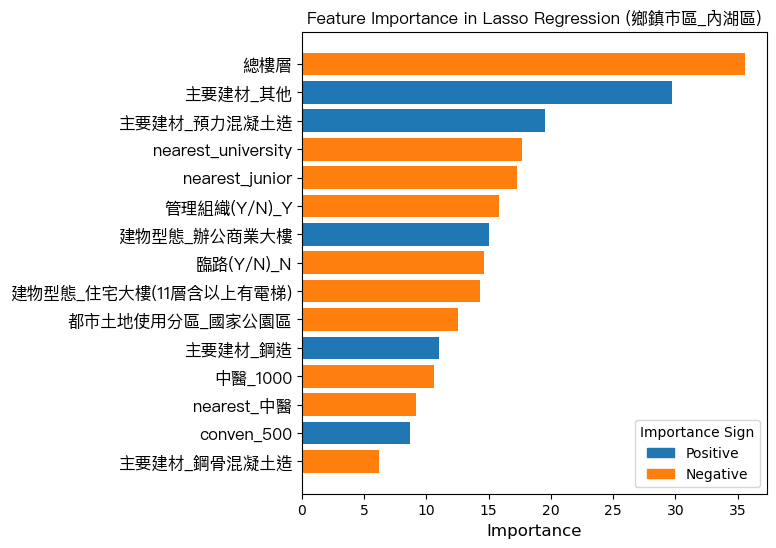

['總樓層', '主要建材_其他', '主要建材_預力混凝土造', 'nearest_university', 'nearest_junior', '管理組織(Y/N)_Y', '建物型態_辦公商業大樓', '臨路(Y/N)_N', '建物型態_住宅大樓(11層含以上有電梯)', '都市土地使用分區_國家公園區', '主要建材_鋼造', '中醫_1000', 'nearest_中醫', 'conven_500', '主要建材_鋼骨混凝土造']
 
lasso training adjusted r2 !:  0.5596527613888016
lasso testing adjusted r2 !:  -0.4581157360131276

保留 64 個係數
收縮至0(被刪除的係數)為:
 Index(['交易日', '緯度', '土地', '建物', '車位', '土地移轉坪數', '建物移轉坪數', '格局-房數', '格局-廳數',
       '格局-衛浴數',
       ...
       '貸款利率_12', '貸款利率_18', '貸款利率_21', '貸款利率_27', '貸款利率_30', '貸款利率_33',
       '貸款利率_36', '單價_1', '單價_9', '單價_20'],
      dtype='object', length=124), 
共 124 個

0.1547285079532177


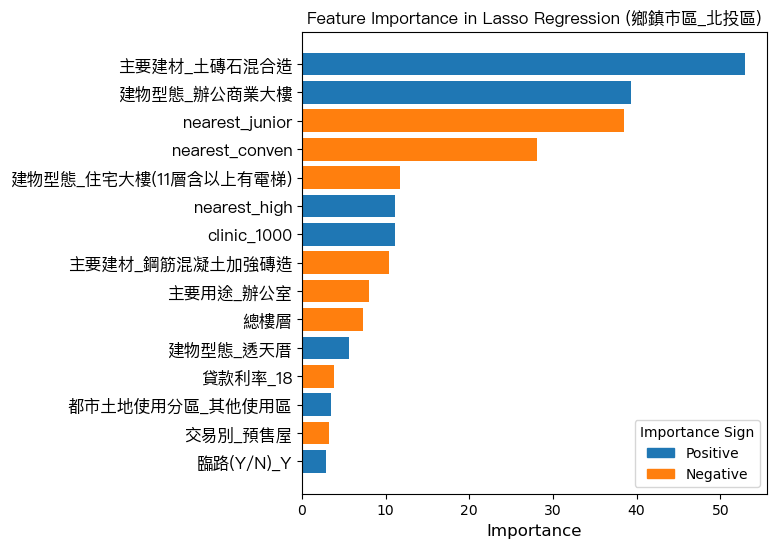

['主要建材_土磚石混合造', '建物型態_辦公商業大樓', 'nearest_junior', 'nearest_conven', '建物型態_住宅大樓(11層含以上有電梯)', 'nearest_high', 'clinic_1000', '主要建材_鋼筋混凝土加強磚造', '主要用途_辦公室', '總樓層', '建物型態_透天厝', '貸款利率_18', '都市土地使用分區_其他使用區', '交易別_預售屋', '臨路(Y/N)_Y']
 
lasso training adjusted r2 !:  0.6060845750482076
lasso testing adjusted r2 !:  0.6369984238478901

保留 45 個係數
收縮至0(被刪除的係數)為:
 Index(['交易日', '緯度', '經度', '土地', '建物', '車位', '土地移轉坪數', '總樓層', '建物移轉坪數', '格局-房數',
       ...
       '貸款利率_15', '貸款利率_18', '貸款利率_24', '貸款利率_27', '貸款利率_30', '貸款利率_33',
       '貸款利率_36', '單價_1', '單價_9', '單價_24'],
      dtype='object', length=143), 
共 143 個

0.04124518511951567


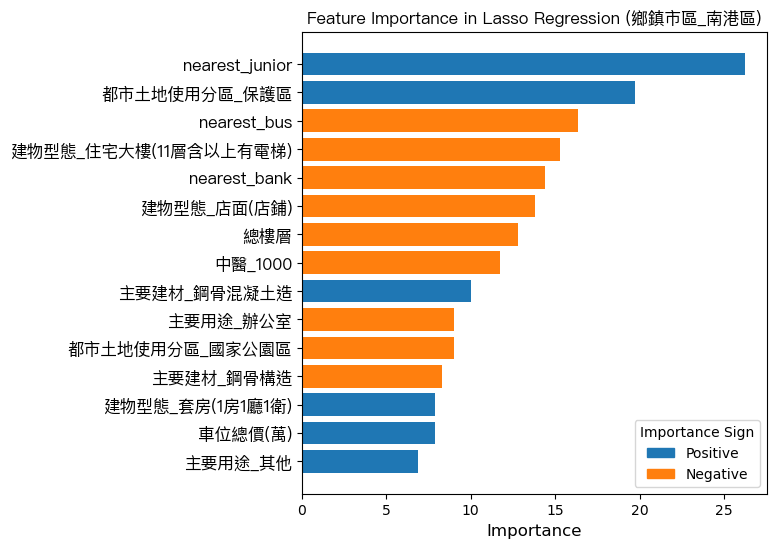

['nearest_junior', '都市土地使用分區_保護區', 'nearest_bus', '建物型態_住宅大樓(11層含以上有電梯)', 'nearest_bank', '建物型態_店面(店鋪)', '總樓層', '中醫_1000', '主要建材_鋼骨混凝土造', '主要用途_辦公室', '都市土地使用分區_國家公園區', '主要建材_鋼骨構造', '建物型態_套房(1房1廳1衛)', '車位總價(萬)', '主要用途_其他']
 
lasso training adjusted r2 !:  0.7600259847393996
lasso testing adjusted r2 !:  0.5472267903807647

保留 67 個係數
收縮至0(被刪除的係數)為:
 Index(['交易日', '緯度', '經度', '建物', '車位', '土地移轉坪數', '總樓層', '建物移轉坪數', '格局-房數',
       '格局-廳數',
       ...
       '失業率_30', '失業率_33', '失業率_36', '貸款利率_6', '貸款利率_15', '貸款利率_27', '貸款利率_30',
       '貸款利率_33', '貸款利率_36', '單價_24'],
      dtype='object', length=121), 
共 121 個

0.2673637039231968


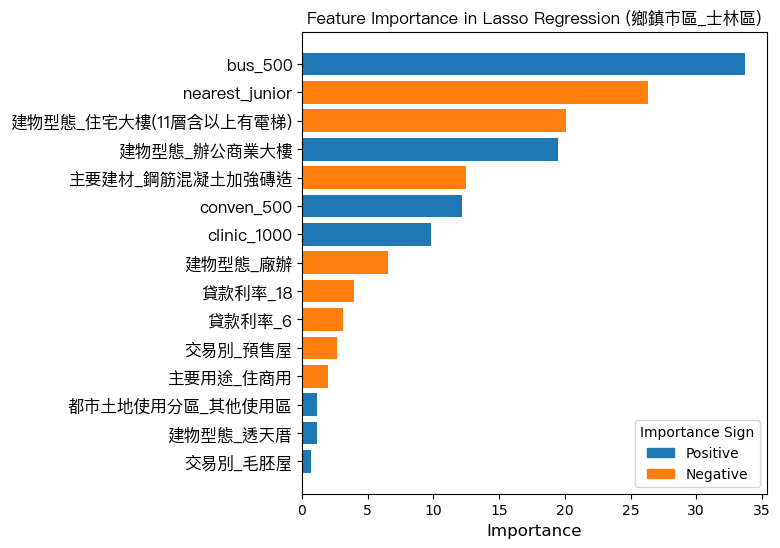

['bus_500', 'nearest_junior', '建物型態_住宅大樓(11層含以上有電梯)', '建物型態_辦公商業大樓', '主要建材_鋼筋混凝土加強磚造', 'conven_500', 'clinic_1000', '建物型態_廠辦', '貸款利率_18', '貸款利率_6', '交易別_預售屋', '主要用途_住商用', '都市土地使用分區_其他使用區', '建物型態_透天厝', '交易別_毛胚屋']
 
lasso training adjusted r2 !:  0.3807784445826716
lasso testing adjusted r2 !:  0.35876558426822236

保留 42 個係數
收縮至0(被刪除的係數)為:
 Index(['交易日', '緯度', '經度', '土地', '建物', '車位', '土地移轉坪數', '總樓層', '屋齡(年)', '建物移轉坪數',
       ...
       '貸款利率_15', '貸款利率_18', '貸款利率_24', '貸款利率_27', '貸款利率_30', '貸款利率_33',
       '貸款利率_36', '單價_1', '單價_8', '單價_24'],
      dtype='object', length=146), 
共 146 個

0.06433497708592642


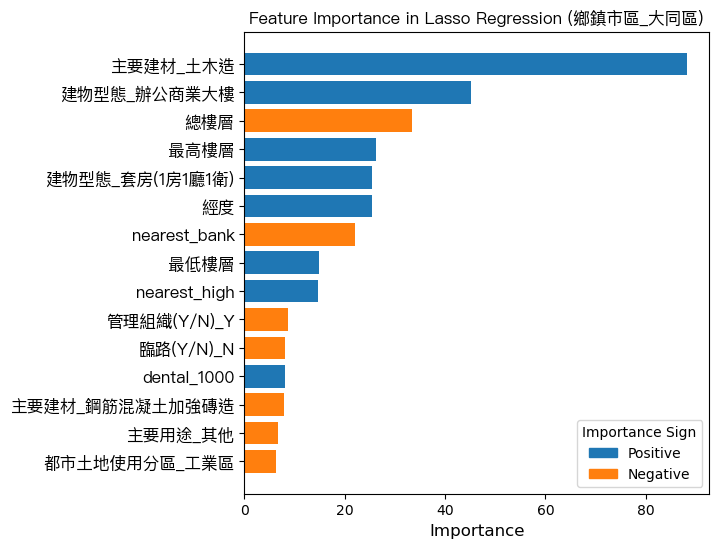

['主要建材_土木造', '建物型態_辦公商業大樓', '總樓層', '最高樓層', '建物型態_套房(1房1廳1衛)', '經度', 'nearest_bank', '最低樓層', 'nearest_high', '管理組織(Y/N)_Y', '臨路(Y/N)_N', 'dental_1000', '主要建材_鋼筋混凝土加強磚造', '主要用途_其他', '都市土地使用分區_工業區']
 
lasso training adjusted r2 !:  0.6346775833309648
lasso testing adjusted r2 !:  0.15949319308769716

保留 58 個係數
收縮至0(被刪除的係數)為:
 Index(['交易日', '緯度', '經度', '建物', '車位', '土地移轉坪數', '總樓層', '建物移轉坪數', '格局-房數',
       '格局-廳數',
       ...
       '貸款利率_3', '貸款利率_9', '貸款利率_12', '貸款利率_18', '貸款利率_21', '貸款利率_24',
       '貸款利率_27', '貸款利率_30', '貸款利率_33', '貸款利率_36'],
      dtype='object', length=130), 
共 130 個

0.16917615761370783


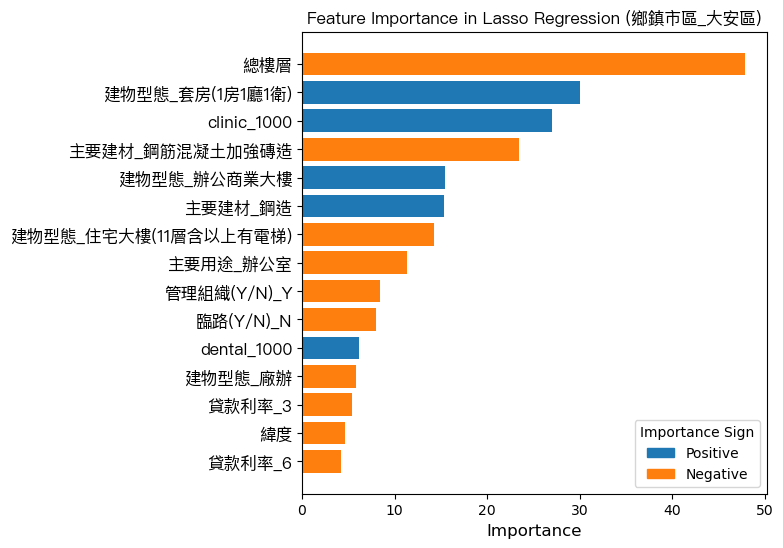

['總樓層', '建物型態_套房(1房1廳1衛)', 'clinic_1000', '主要建材_鋼筋混凝土加強磚造', '建物型態_辦公商業大樓', '主要建材_鋼造', '建物型態_住宅大樓(11層含以上有電梯)', '主要用途_辦公室', '管理組織(Y/N)_Y', '臨路(Y/N)_N', 'dental_1000', '建物型態_廠辦', '貸款利率_3', '緯度', '貸款利率_6']
 
lasso training adjusted r2 !:  0.572624683906189
lasso testing adjusted r2 !:  0.33402517853144564

保留 50 個係數
收縮至0(被刪除的係數)為:
 Index(['交易日', '緯度', '土地', '建物', '車位', '土地移轉坪數', '總樓層', '建物移轉坪數', '格局-房數',
       '格局-廳數',
       ...
       '失業率_36', '貸款利率_3', '貸款利率_12', '貸款利率_15', '貸款利率_24', '貸款利率_27',
       '貸款利率_30', '貸款利率_33', '貸款利率_36', '單價_24'],
      dtype='object', length=138), 
共 138 個

0.04705762509769434


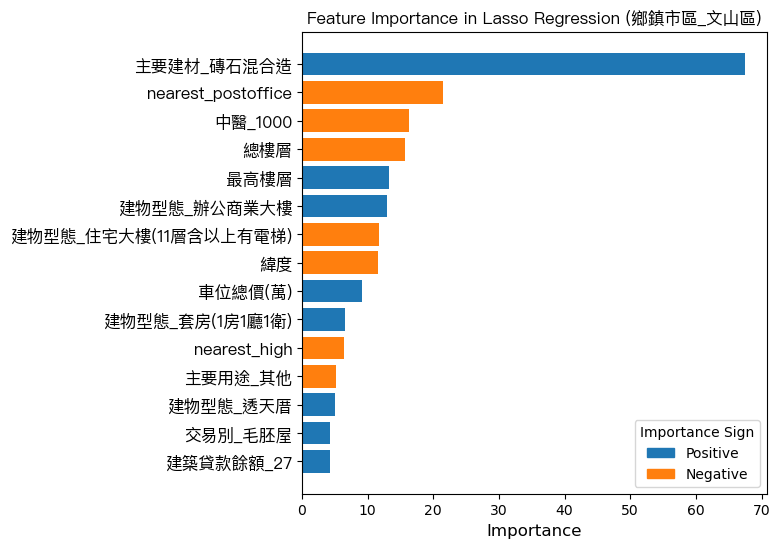

['主要建材_磚石混合造', 'nearest_postoffice', '中醫_1000', '總樓層', '最高樓層', '建物型態_辦公商業大樓', '建物型態_住宅大樓(11層含以上有電梯)', '緯度', '車位總價(萬)', '建物型態_套房(1房1廳1衛)', 'nearest_high', '主要用途_其他', '建物型態_透天厝', '交易別_毛胚屋', '建築貸款餘額_27']
 
lasso training adjusted r2 !:  0.5863618423519964
lasso testing adjusted r2 !:  0.5098039314761942

保留 61 個係數
收縮至0(被刪除的係數)為:
 Index(['交易日', '緯度', '土地', '建物', '車位', '土地移轉坪數', '總樓層', '建物移轉坪數', '格局-房數',
       '格局-廳數',
       ...
       '貸款利率_3', '貸款利率_9', '貸款利率_15', '貸款利率_18', '貸款利率_24', '貸款利率_27',
       '貸款利率_30', '貸款利率_33', '貸款利率_36', '單價_24'],
      dtype='object', length=127), 
共 127 個

0.12926196050801503


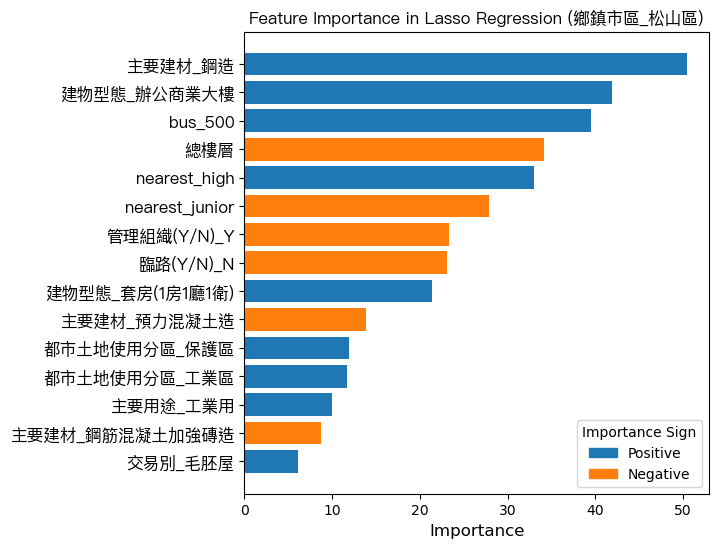

['主要建材_鋼造', '建物型態_辦公商業大樓', 'bus_500', '總樓層', 'nearest_high', 'nearest_junior', '管理組織(Y/N)_Y', '臨路(Y/N)_N', '建物型態_套房(1房1廳1衛)', '主要建材_預力混凝土造', '都市土地使用分區_保護區', '都市土地使用分區_工業區', '主要用途_工業用', '主要建材_鋼筋混凝土加強磚造', '交易別_毛胚屋']
 
lasso training adjusted r2 !:  0.7692103993319168
lasso testing adjusted r2 !:  0.4028957407792887

保留 55 個係數
收縮至0(被刪除的係數)為:
 Index(['交易日', '緯度', '經度', '土地', '建物', '車位', '土地移轉坪數', '總樓層', '建物移轉坪數', '格局-房數',
       ...
       '貸款利率_6', '貸款利率_15', '貸款利率_21', '貸款利率_24', '貸款利率_27', '貸款利率_30',
       '貸款利率_33', '貸款利率_36', '單價_16', '單價_24'],
      dtype='object', length=133), 
共 133 個

0.21034373353690905


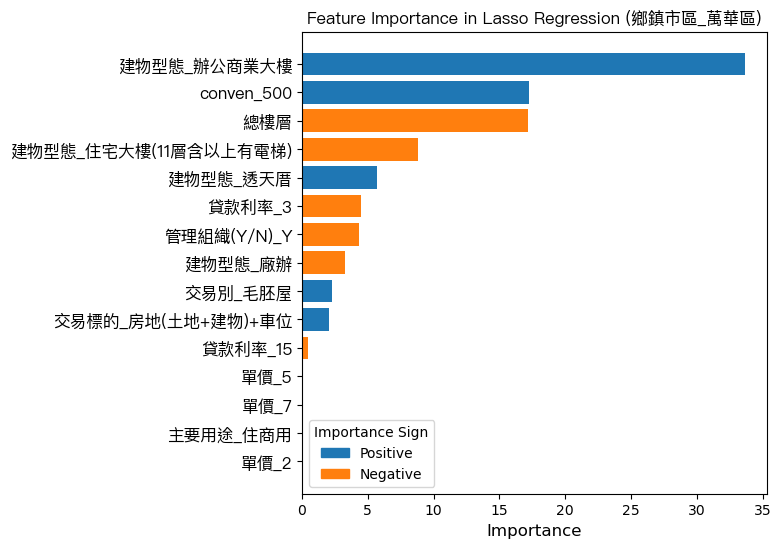

['建物型態_辦公商業大樓', 'conven_500', '總樓層', '建物型態_住宅大樓(11層含以上有電梯)', '建物型態_透天厝', '貸款利率_3', '管理組織(Y/N)_Y', '建物型態_廠辦', '交易別_毛胚屋', '交易標的_房地(土地+建物)+車位', '貸款利率_15', '單價_5', '單價_7', '主要用途_住商用', '單價_2']
 
lasso training adjusted r2 !:  0.39747012296313466
lasso testing adjusted r2 !:  0.3668860641025503

保留 30 個係數
收縮至0(被刪除的係數)為:
 Index(['交易日', '緯度', '經度', '土地', '建物', '車位', '土地移轉坪數', '總樓層', '建物移轉坪數', '格局-房數',
       ...
       '貸款利率_27', '貸款利率_30', '貸款利率_33', '貸款利率_36', '單價_2', '單價_4', '單價_19',
       '單價_22', '單價_23', '單價_24'],
      dtype='object', length=158), 
共 158 個



In [44]:
df_train_per = []
df_test_per = []
df_importance = {}
df_coef = {}
new_train_adj = [] # 新的 adj r-squared
new_test_adj = [] # 新的 adj r-squared
alphas = []


for (name_X, X_train), (name_y, y_train), (name_X, X_test), (name_y, y_test) in zip(X_train_dict.items(), y_train_dict.items(), X_test_dict.items(), y_test_dict.items()):
    if name_X != name_y:
        raise ValueError("X和y的資料集名稱不匹配")
        
    tscv = TimeSeriesSplit(n_splits=5)
    lasso_cv = LassoCV(alphas=None, cv=tscv, max_iter=10000, random_state=2023)
    lasso_reg = lasso_cv.fit(X_train, y_train)
    print(lasso_reg.alpha_)
    alphas.append(lasso_reg.alpha_)

    train_per, test_per = performance(lasso_reg, X_train, y_train, X_test, y_test, f"{name_X} Lasso Regression:")
    imp, _ = featureplot(lasso_reg.coef_, 15, data12_train.columns, f'Feature Importance in Lasso Regression ({name_X})') 
    print(imp)
    print(" ")
    
    # lasso adj R-squared需另外算 # 新的 adj r-squared
    # train
    y_train_pred = lasso_reg.predict(X_train)
    train_adj = adjusted_r2(y_train, y_train_pred, X_train.loc[:, lasso_reg.coef_!=0]) # p的計算要扣掉被shrink到0的變數

    # test
    y_test_pred = lasso_reg.predict(X_test)
    test_adj = adjusted_r2(y_test, y_test_pred, X_test.loc[:, lasso_reg.coef_!=0]) # p的計算要扣掉被shrink到0的變數

    new_train_adj.append(train_adj)
    new_test_adj.append(test_adj)
    print("lasso training adjusted r2 !: ", train_adj)
    print("lasso testing adjusted r2 !: ", test_adj)
    
    
    print('')
    df_train_per.append(train_per)
    df_test_per.append(test_per)
    df_importance[name_X] = imp
    df_coef[name_X] = X_train.columns[lasso_reg.coef_==0]
    
    print(f'保留 {len(X_train.columns[lasso_reg.coef_!=0])} 個係數')
    print(f'收縮至0(被刪除的係數)為:\n {X_train.columns[lasso_reg.coef_==0]}, \n共 {len(X_train.columns[lasso_reg.coef_==0])} 個')
    print('')
    
    
lasso_dist_train = pd.DataFrame(df_train_per, columns=['Adjusted R-squared', 'RMSE', 'MAPE'])
lasso_dist_train.index = dist
lasso_dist_train['Adjusted R-squared'] = new_train_adj # 覆蓋掉原本錯誤的 Adjusted R-squared

lasso_dist_test = pd.DataFrame(df_test_per, columns=['Adjusted R-squared', 'RMSE', 'MAPE'])
lasso_dist_test.index = dist
lasso_dist_test['Adjusted R-squared'] = new_test_adj # 覆蓋掉原本錯誤的 Adjusted R-squared


In [45]:
alphas 

[0.19476534027838993,
 0.28135071164543374,
 0.06206431344082846,
 0.038568613832018366,
 0.1547285079532177,
 0.04124518511951567,
 0.2673637039231968,
 0.06433497708592642,
 0.16917615761370783,
 0.04705762509769434,
 0.12926196050801503,
 0.21034373353690905]

lasso_dist_train.to_csv(path_ + r'/lasso_dist_train.csv', sep=',', encoding='utf-8', index=True)
lasso_dist_test.to_csv(path_ + r'/lasso_dist_test.csv', sep=',', encoding='utf-8', index=True)

In [46]:
# 重要15
df_importance

{'鄉鎮市區_中山區': ['建物型態_辦公商業大樓',
  '總樓層',
  '土地移轉坪數',
  '主要建材_鋼筋混凝土加強磚造',
  'clinic_1000',
  '最低樓層',
  '建物型態_住宅大樓(11層含以上有電梯)',
  '臨路(Y/N)_N',
  '建物型態_透天厝',
  '管理組織(Y/N)_Y',
  '主要用途_辦公室',
  '貸款利率_6',
  '最高樓層',
  '都市土地使用分區_其他使用區',
  '主要建材_鋼造'],
 '鄉鎮市區_中正區': ['主要建材_壁式預鑄鋼筋混凝土造',
  '建物型態_辦公商業大樓',
  '總樓層',
  '臨路(Y/N)_N',
  '緯度',
  'bus_500',
  '管理組織(Y/N)_Y',
  '建物型態_住宅大樓(11層含以上有電梯)',
  '主要建材_鋼筋混凝土加強磚造',
  '主要建材_鋼骨混凝土造',
  '主要用途_其他',
  '主要用途_辦公室',
  '貸款利率_3',
  '交易別_毛胚屋',
  '貸款利率_6'],
 '鄉鎮市區_信義區': ['格局-衛浴數',
  '中醫_1000',
  '車位總面積(坪)',
  '建物型態_套房(1房1廳1衛)',
  'dental_1000',
  '建物型態_公寓(5樓含以下無電梯)',
  '總樓層',
  '主要用途_工業用',
  'nearest_mrt',
  '建物型態_辦公商業大樓',
  '主要建材_鋼造',
  '交易別_不動產',
  '車位總價(萬)',
  '主要建材_鋼骨混凝土造',
  '主要建材_鋼筋混凝土加強磚造'],
 '鄉鎮市區_內湖區': ['總樓層',
  '主要建材_其他',
  '主要建材_預力混凝土造',
  'nearest_university',
  'nearest_junior',
  '管理組織(Y/N)_Y',
  '建物型態_辦公商業大樓',
  '臨路(Y/N)_N',
  '建物型態_住宅大樓(11層含以上有電梯)',
  '都市土地使用分區_國家公園區',
  '主要建材_鋼造',
  '中醫_1000',
  'nearest_中醫',
  'conven_500',
  '主要建材_鋼骨混凝土造'],
 '鄉鎮市區_北投

In [47]:
# 收縮至0
df_coef

{'鄉鎮市區_中山區': Index(['交易日', '緯度', '經度', '土地', '建物', '車位', '土地移轉坪數', '建物移轉坪數', '格局-房數',
        '格局-廳數',
        ...
        '貸款利率_6', '貸款利率_12', '貸款利率_15', '貸款利率_24', '貸款利率_27', '貸款利率_30',
        '貸款利率_33', '貸款利率_36', '單價_22', '單價_24'],
       dtype='object', length=145),
 '鄉鎮市區_中正區': Index(['交易日', '緯度', '土地', '建物', '車位', '土地移轉坪數', '總樓層', '建物移轉坪數', '格局-房數',
        '格局-廳數',
        ...
        '貸款利率_21', '貸款利率_24', '貸款利率_27', '貸款利率_30', '貸款利率_33', '貸款利率_36',
        '單價_6', '單價_12', '單價_21', '單價_24'],
       dtype='object', length=148),
 '鄉鎮市區_信義區': Index(['交易日', '緯度', '經度', '土地', '建物', '車位', '土地移轉坪數', '建物移轉坪數', '格局-房數',
        '格局-廳數',
        ...
        '貸款利率_3', '貸款利率_6', '貸款利率_12', '貸款利率_15', '貸款利率_24', '貸款利率_27',
        '貸款利率_30', '貸款利率_33', '貸款利率_36', '單價_24'],
       dtype='object', length=118),
 '鄉鎮市區_內湖區': Index(['交易日', '緯度', '土地', '建物', '車位', '土地移轉坪數', '建物移轉坪數', '格局-房數', '格局-廳數',
        '格局-衛浴數',
        ...
        '貸款利率_12', '貸款利率_18', '貸款利率_21', '貸款利率_27', '貸款利率_30', '

In [48]:
import pickle
with open(path_ + r'/lasso_shrink_to_0_dist.pickle', 'wb') as file:
    pickle.dump(df_coef, file)

In [49]:
# 每個區平均收縮到0的數量
lengths = [len(value) for value in df_coef.values()]
np.mean(lengths)

135.91666666666666

In [50]:
# lasso_dist_train = pd.read_csv(path_ + r'/lasso_dist_train.csv')
# lasso_dist_test = pd.read_csv(path_ + r'/lasso_dist_test.csv')
# print('分區 training Adjusted R-squared 加權平均', np.sum(lasso_dist_train['Adjusted R-squared']*(lasso_dist_train['count']/np.sum(lasso_dist_train['count']))))
# print('分區 testing Adjusted R-squared 加權平均', np.sum(lasso_dist_test['Adjusted R-squared']*(lasso_dist_test['count']/np.sum(lasso_dist_test['count']))))

### forward

鄉鎮市區_中山區


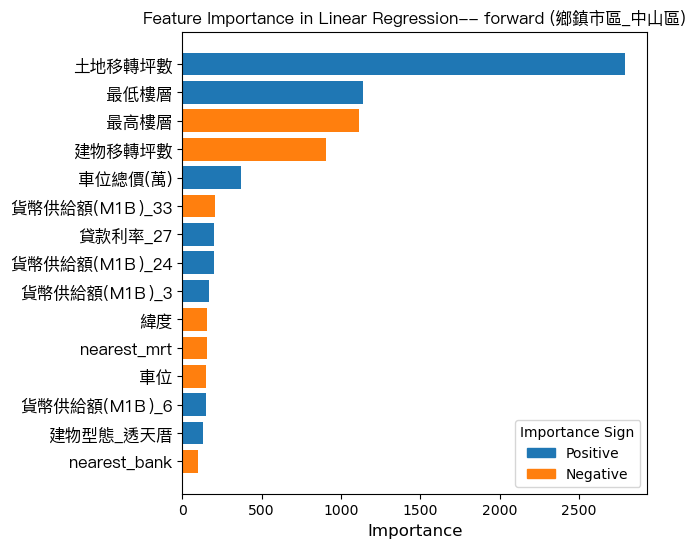


鄉鎮市區_中正區


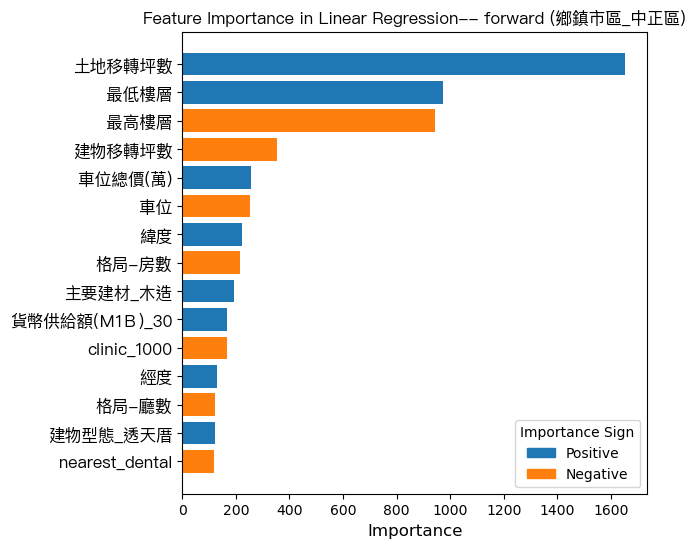


鄉鎮市區_信義區


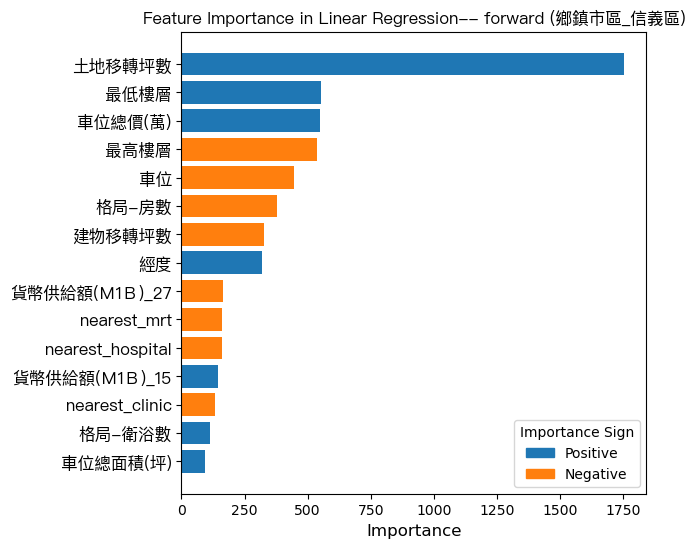


鄉鎮市區_內湖區


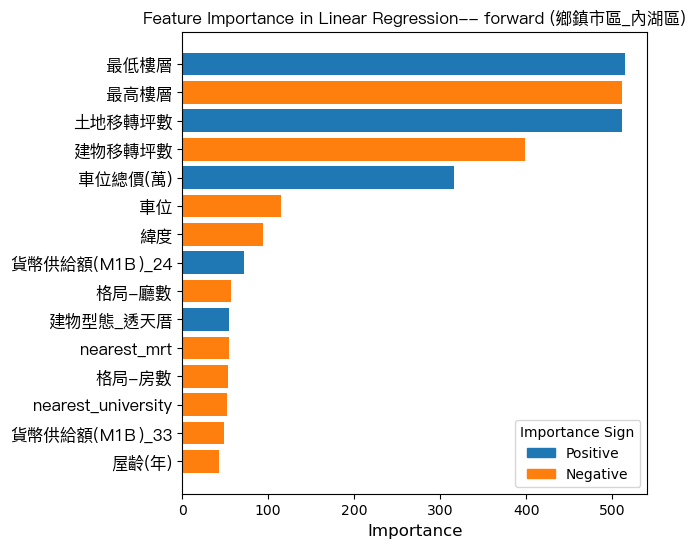


鄉鎮市區_北投區


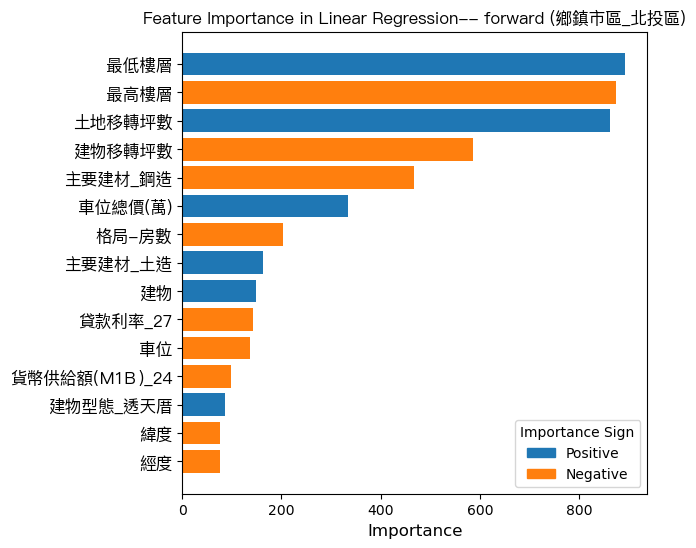


鄉鎮市區_南港區


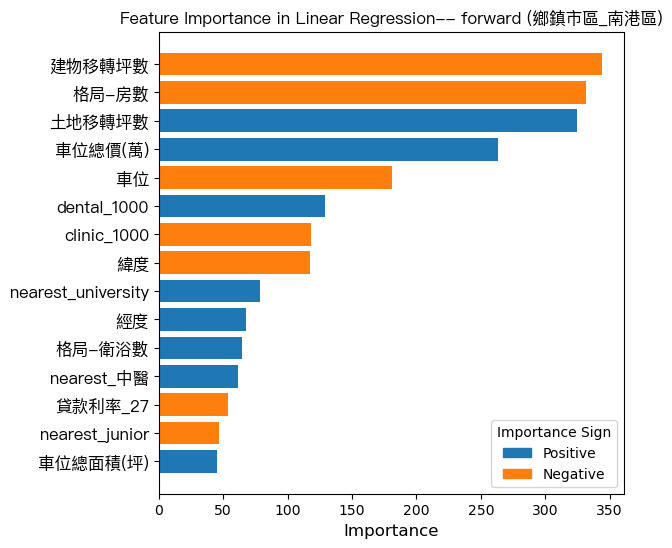


鄉鎮市區_士林區


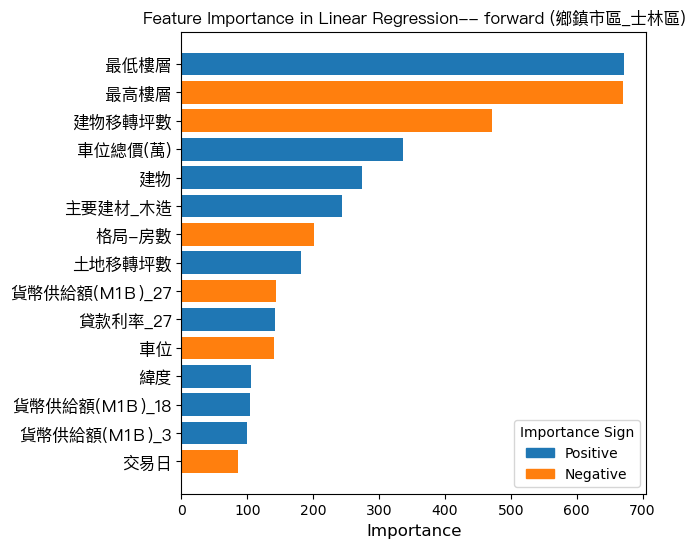


鄉鎮市區_大同區


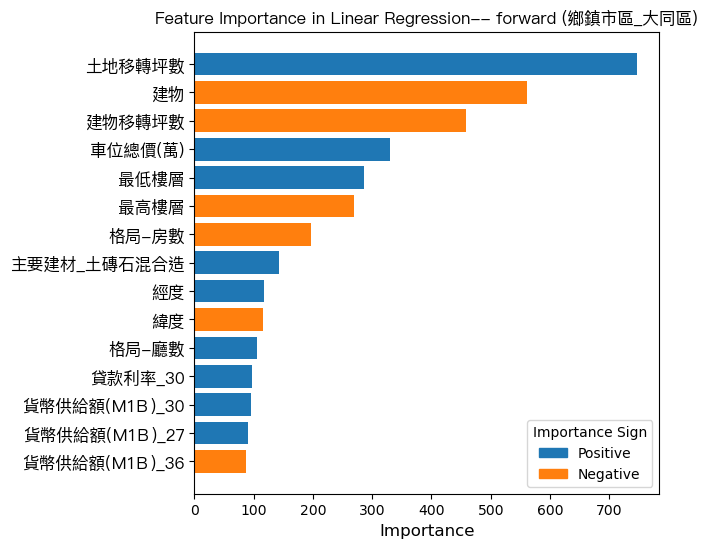


鄉鎮市區_大安區


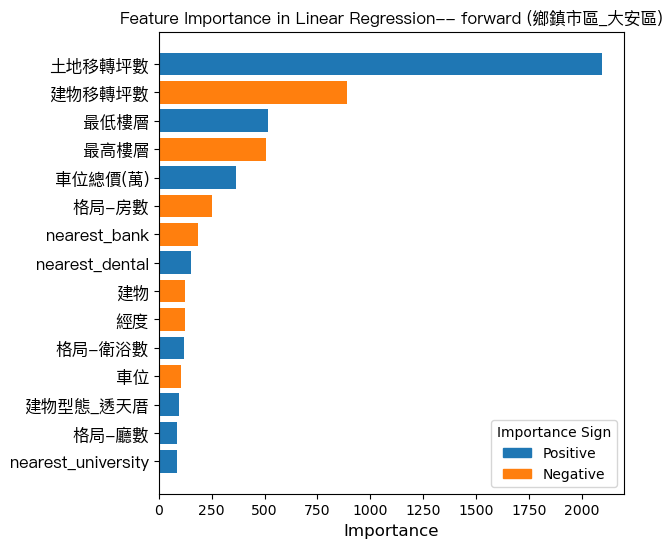


鄉鎮市區_文山區


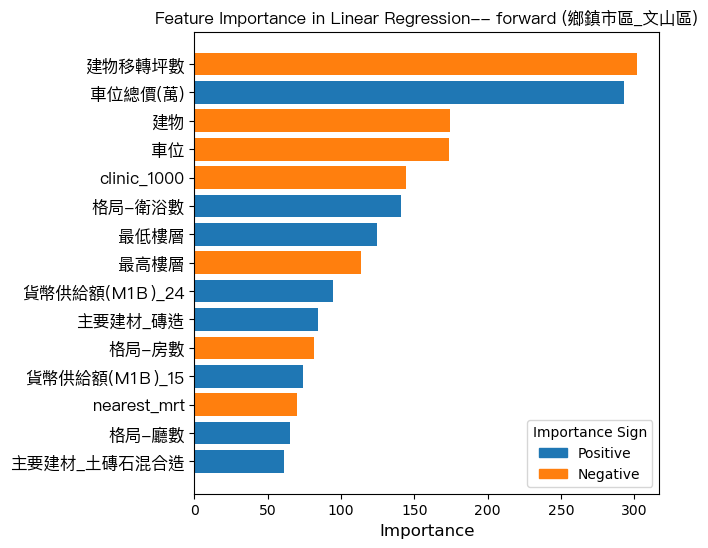


鄉鎮市區_松山區


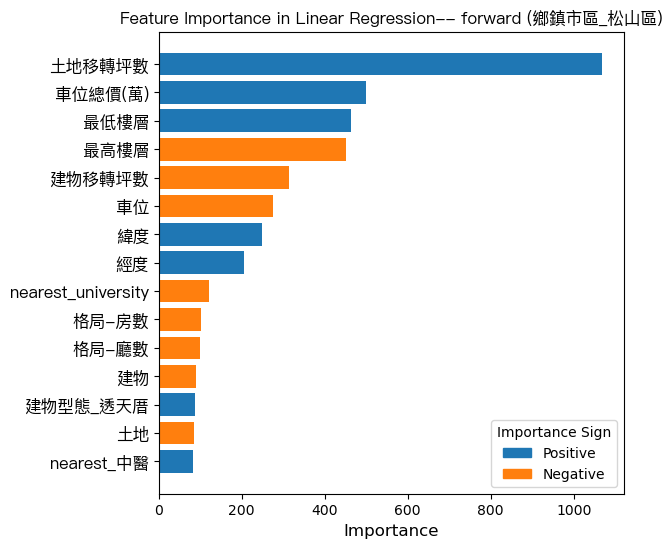


鄉鎮市區_萬華區


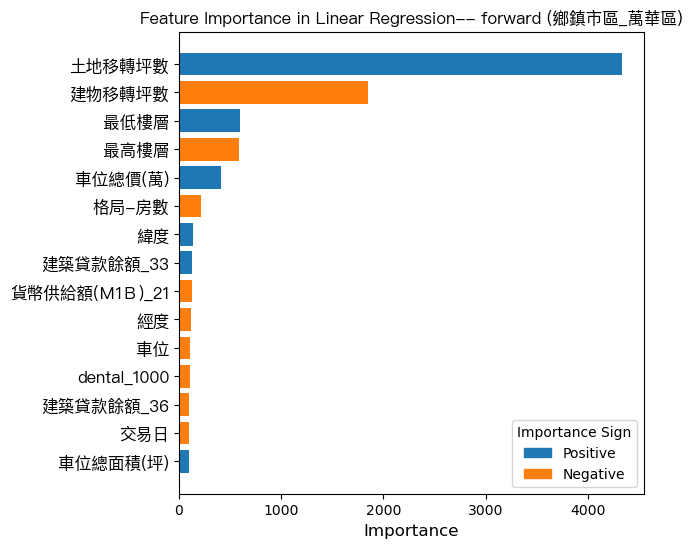

In [51]:
df_train_per = []
df_test_per = []
selected_features_list = {}
df_importance = {}

for (name_X, X_train), (name_y, y_train), (name_X, X_test), (name_y, y_test) in zip(X_train_dict.items(), y_train_dict.items(), X_test_dict.items(), y_test_dict.items()):
    if name_X != name_y:
        raise ValueError("X和y的資料集名稱不匹配")
        
    print(name_X)
    sfs_linear = SFS(linear, 
          k_features='best', 
          forward=True, 
          floating=False, 
          scoring='r2',
          cv=0)
    sfs_linear_reg = sfs_linear.fit(X_train, y_train)
    
    selected_features = X_train.columns[list(sfs_linear_reg.k_feature_idx_)]

    X_train_selected = sfs_linear_reg.transform(X_train)
    X_test_selected = sfs_linear_reg.transform(X_test)
    
    linear = linear_model.LinearRegression()
    linear_reg = linear.fit(X_train_selected, y_train)
    
    train_per, test_per = performance(linear_reg, X_train_selected, y_train, X_test_selected, y_test, f"{name_X} Linear Regression-- forward:")

    imp, _ = featureplot(linear_reg.coef_, 15, selected_features, f'Feature Importance in Linear Regression-- forward ({name_X})') 
    print('')
    df_train_per.append(train_per)
    df_test_per.append(test_per)
    
    selected_features_list[name_X] = selected_features
    df_importance[name_X] = imp
    
    
forward_dist_train = pd.DataFrame(df_train_per, columns=['Adjusted R-squared', 'RMSE', 'MAPE'])
forward_dist_train.index = dist
forward_dist_test = pd.DataFrame(df_test_per, columns=['Adjusted R-squared', 'RMSE', 'MAPE'])
forward_dist_test.index = dist

In [52]:
forward_dist_train.to_csv(path_ + r'/forward_dist_train.csv', sep=',', encoding='utf-8', index=True)
forward_dist_test.to_csv(path_ + r'/forward_dist_test.csv', sep=',', encoding='utf-8', index=True)

In [53]:
# forward 移除的變數
difference_dict = {}

for district, item in selected_features_list.items():
    difference = X_train.columns.difference(item)
    difference_dict[district] = difference

In [54]:
selected_features_list

{'鄉鎮市區_中山區': Index(['交易日', '緯度', '經度', '土地', '建物', '車位', '土地移轉坪數', '總樓層', '屋齡(年)', '建物移轉坪數',
        ...
        '單價_15', '單價_16', '單價_17', '單價_18', '單價_19', '單價_20', '單價_21', '單價_22',
        '單價_23', '單價_24'],
       dtype='object', length=119),
 '鄉鎮市區_中正區': Index(['交易日', '緯度', '經度', '土地', '建物', '車位', '土地移轉坪數', '總樓層', '屋齡(年)', '建物移轉坪數',
        ...
        '單價_15', '單價_16', '單價_17', '單價_18', '單價_19', '單價_20', '單價_21', '單價_22',
        '單價_23', '單價_24'],
       dtype='object', length=119),
 '鄉鎮市區_信義區': Index(['交易日', '緯度', '經度', '土地', '建物', '車位', '土地移轉坪數', '總樓層', '屋齡(年)', '建物移轉坪數',
        ...
        '單價_15', '單價_16', '單價_17', '單價_18', '單價_19', '單價_20', '單價_21', '單價_22',
        '單價_23', '單價_24'],
       dtype='object', length=121),
 '鄉鎮市區_內湖區': Index(['交易日', '緯度', '經度', '土地', '建物', '車位', '土地移轉坪數', '總樓層', '屋齡(年)', '建物移轉坪數',
        ...
        '單價_15', '單價_16', '單價_17', '單價_18', '單價_19', '單價_20', '單價_21', '單價_22',
        '單價_23', '單價_24'],
       dtype='object', length=124),
 '鄉鎮市區_北

In [55]:
print('移除的變數數量', [len(value) for value in difference_dict.values()])
print('保留的變數數量', [len(value) for value in selected_features_list.values()])

移除的變數數量 [69, 69, 67, 64, 62, 69, 65, 66, 53, 70, 62, 65]
保留的變數數量 [119, 119, 121, 124, 126, 119, 123, 122, 135, 118, 126, 123]


In [56]:
# forward 移除的變數
difference_dict

{'鄉鎮市區_中山區': Index(['主要建材_土木磚混合造', '主要建材_土木造', '主要建材_土磚石混合造', '主要建材_土造', '主要建材_壁式預鑄鋼筋混凝土造',
        '主要建材_混凝土造', '主要建材_煉瓦造', '主要建材_石造', '主要建材_磚石混合造', '主要建材_磚造', '主要建材_鋼造',
        '主要建材_鋼骨鋼筋混凝土造', '主要建材_鐵造', '主要建材_預力混凝土造', '主要用途_住宅', '主要用途_工業用',
        '交易別_預售屋', '交易標的_房地(土地+建物)+車位', '失業率_12', '失業率_15', '失業率_18', '失業率_27',
        '失業率_33', '失業率_36', '失業率_9', '建物型態_套房(1房1廳1衛)', '建物型態_廠辦', '建築貸款餘額_12',
        '建築貸款餘額_18', '建築貸款餘額_24', '建築貸款餘額_27', '建築貸款餘額_30', '建築貸款餘額_33',
        '建築貸款餘額_36', '建築貸款餘額_9', '消費者物價指數_27', '消費者物價指數_30', '消費者物價指數_36',
        '消費者物價指數_6', '消費者物價指數_9', '管理組織(Y/N)_N', '貨幣供給額(Ｍ1Ｂ)_12',
        '貨幣供給額(Ｍ1Ｂ)_27', '貨幣供給額(Ｍ1Ｂ)_9', '貸款利率_15', '貸款利率_18', '貸款利率_21',
        '貸款利率_24', '貸款利率_3', '貸款利率_30', '貸款利率_33', '都市土地使用分區_保護區',
        '都市土地使用分區_國家公園區', '都市土地使用分區_工業區', '都市土地使用分區_行政區', '都市土地使用分區_農業區',
        '鄉鎮市區_中山區', '鄉鎮市區_中正區', '鄉鎮市區_信義區', '鄉鎮市區_內湖區', '鄉鎮市區_北投區', '鄉鎮市區_南港區',
        '鄉鎮市區_士林區', '鄉鎮市區_大同區', '鄉鎮市區_大安區', '鄉鎮市區_文山區', '鄉鎮市區_松山區', '鄉鎮市區_萬華區',
     